## Preprocessing and classification for a breast cancer dataset

data source: https://www.kaggle.com/code/jyotsanakunwer/breast-cancer-classification-95-9-accuracy/data

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import linear_model
from sklearn import metrics
import pydotplus
from IPython.display import Image
data = pd.read_csv("data.csv")
data = data.drop(columns = ['Unnamed: 32', 'id'])
data

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


The first thing done during preprocessing was to drop the id column, as it provided no relevant information to the problem of diagnosis prediction. Subsequently; incomplete, noisy, inconsistent, and intentional data was checked for. As only one dataset was used, inconsistent data was not found. In addition, no incomplete data was found; 0s present in some attributes still describe it rather than serving as a placeholder. Evaluating for noise actually yielded some interference. To accomplish this, z-scores were calculated for each value of a specific attribute relative to its mean, a threshold of 3 sd being used. The outliers were then removed using bin mean smoothing.

In [21]:
data2 = data.drop(columns = ['diagnosis'])
print('Number of outliers in each column:')
for col in data2.columns:
    outliers = []
    mean = np.mean(data2[col].values)
    std = np.std(data2[col].values)
    for val in data2[col].values:
        z = (val-mean)/std
        if z < -3 or z > 3:
            outliers.append(val)
    print(col, ": ", len(outliers))

Number of outliers in each column:
radius_mean :  5
texture_mean :  4
perimeter_mean :  7
area_mean :  8
smoothness_mean :  5
compactness_mean :  9
concavity_mean :  9
concave points_mean :  6
symmetry_mean :  5
fractal_dimension_mean :  7
radius_se :  7
texture_se :  9
perimeter_se :  8
area_se :  6
smoothness_se :  7
compactness_se :  12
concavity_se :  6
concave points_se :  6
symmetry_se :  11
fractal_dimension_se :  10
radius_worst :  6
texture_worst :  4
perimeter_worst :  6
area_worst :  10
smoothness_worst :  3
compactness_worst :  10
concavity_worst :  7
concave points_worst :  0
symmetry_worst :  9
fractal_dimension_worst :  9


In [22]:
def set_to_mean(row, bin_name, col, frame):
    meaned_values = []
    bin_interval = row[bin_name]
    for val in frame[col]:
        if val in bin_interval:
            meaned_values.append(val)
    row[col] = np.mean(meaned_values)
    return row

data2 = data.drop(columns = ['diagnosis'])
columns = data2.columns
drop_columns = []
for col in columns:
    bin_name = 'bin_' + col
    data2[bin_name] = pd.qcut(data2[col], q=10, precision=5)
    drop_columns.append(bin_name)
for col in columns:
    bin_name = 'bin_' + col
    data2 = data2.apply(lambda f: set_to_mean(f, bin_name, col, data2), axis=1)
data2 = data2.drop(columns = drop_columns)
data2

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,18.324483,12.804035,120.581034,1042.763158,0.122521,0.219140,0.265454,0.132232,0.235960,0.077847,...,26.605614,16.321754,179.387719,2185.684211,0.175925,0.599754,0.717389,0.239014,0.422275,0.123433
1,21.453750,17.354821,142.741071,1438.157895,0.086125,0.075380,0.099248,0.073251,0.182196,0.056189,...,26.605614,22.798947,179.387719,2185.684211,0.123254,0.198891,0.256079,0.192677,0.276154,0.092135
2,21.453750,20.553860,142.741071,1438.157895,0.110893,0.157588,0.172896,0.132232,0.207674,0.059462,...,21.936842,25.992857,146.207143,2185.684211,0.146191,0.404930,0.489270,0.239014,0.422275,0.086050
3,11.691754,20.553860,79.494386,367.069643,0.122521,0.219140,0.265454,0.132232,0.235960,0.077847,...,14.486379,25.992857,101.213214,567.210526,0.175925,0.599754,0.717389,0.239014,0.422275,0.123433
4,21.453750,14.920175,142.741071,1438.157895,0.101166,0.130484,0.172896,0.132232,0.182196,0.057865,...,21.936842,16.321754,146.207143,1479.500000,0.134645,0.198891,0.383311,0.163167,0.234782,0.075398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.453750,21.816034,142.741071,1438.157895,0.110893,0.114774,0.265454,0.132232,0.175559,0.056189,...,26.605614,25.992857,179.387719,2185.684211,0.140376,0.198891,0.383311,0.239014,0.205172,0.071521
565,21.453750,27.803158,142.741071,1438.157895,0.097740,0.101148,0.129684,0.091150,0.175559,0.053551,...,26.605614,37.330526,146.207143,2185.684211,0.116532,0.198891,0.319925,0.163167,0.263612,0.067877
566,15.914561,27.803158,104.774912,787.471930,0.086125,0.101148,0.099248,0.056049,0.161972,0.056189,...,18.811053,37.330526,125.343860,1093.541379,0.116532,0.335253,0.319925,0.137758,0.205172,0.078330
567,21.453750,27.803158,142.741071,1438.157895,0.122521,0.219140,0.265454,0.132232,0.235960,0.069533,...,26.605614,37.330526,179.387719,2185.684211,0.175925,0.599754,0.717389,0.239014,0.422275,0.123433


In [23]:
for col in data2.columns:
    outliers = []
    mean = np.mean(data2[col].values)
    std = np.std(data2[col].values)
    for val in data2[col].values:
        z = (val-mean)/std
        if z < -3 or z > 3:
            outliers.append(val)
    print(col, ": ", len(outliers))

radius_mean :  0
texture_mean :  0
perimeter_mean :  0
area_mean :  0
smoothness_mean :  0
compactness_mean :  0
concavity_mean :  0
concave points_mean :  0
symmetry_mean :  0
fractal_dimension_mean :  0
radius_se :  0
texture_se :  0
perimeter_se :  0
area_se :  0
smoothness_se :  0
compactness_se :  0
concavity_se :  0
concave points_se :  0
symmetry_se :  0
fractal_dimension_se :  0
radius_worst :  0
texture_worst :  0
perimeter_worst :  0
area_worst :  0
smoothness_worst :  0
compactness_worst :  0
concavity_worst :  0
concave points_worst :  0
symmetry_worst :  0
fractal_dimension_worst :  0


In [24]:
# Reorders the columns so the next sections work properly

data2['diagnosis'] = data['diagnosis']
columns = list(data2)
columns.insert(0, columns.pop(columns.index('diagnosis')))
data2 = data2.loc[:, columns]
dataset = data2
dataset

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,18.324483,12.804035,120.581034,1042.763158,0.122521,0.219140,0.265454,0.132232,0.235960,...,26.605614,16.321754,179.387719,2185.684211,0.175925,0.599754,0.717389,0.239014,0.422275,0.123433
1,M,21.453750,17.354821,142.741071,1438.157895,0.086125,0.075380,0.099248,0.073251,0.182196,...,26.605614,22.798947,179.387719,2185.684211,0.123254,0.198891,0.256079,0.192677,0.276154,0.092135
2,M,21.453750,20.553860,142.741071,1438.157895,0.110893,0.157588,0.172896,0.132232,0.207674,...,21.936842,25.992857,146.207143,2185.684211,0.146191,0.404930,0.489270,0.239014,0.422275,0.086050
3,M,11.691754,20.553860,79.494386,367.069643,0.122521,0.219140,0.265454,0.132232,0.235960,...,14.486379,25.992857,101.213214,567.210526,0.175925,0.599754,0.717389,0.239014,0.422275,0.123433
4,M,21.453750,14.920175,142.741071,1438.157895,0.101166,0.130484,0.172896,0.132232,0.182196,...,21.936842,16.321754,146.207143,1479.500000,0.134645,0.198891,0.383311,0.163167,0.234782,0.075398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.453750,21.816034,142.741071,1438.157895,0.110893,0.114774,0.265454,0.132232,0.175559,...,26.605614,25.992857,179.387719,2185.684211,0.140376,0.198891,0.383311,0.239014,0.205172,0.071521
565,M,21.453750,27.803158,142.741071,1438.157895,0.097740,0.101148,0.129684,0.091150,0.175559,...,26.605614,37.330526,146.207143,2185.684211,0.116532,0.198891,0.319925,0.163167,0.263612,0.067877
566,M,15.914561,27.803158,104.774912,787.471930,0.086125,0.101148,0.099248,0.056049,0.161972,...,18.811053,37.330526,125.343860,1093.541379,0.116532,0.335253,0.319925,0.137758,0.205172,0.078330
567,M,21.453750,27.803158,142.741071,1438.157895,0.122521,0.219140,0.265454,0.132232,0.235960,...,26.605614,37.330526,179.387719,2185.684211,0.175925,0.599754,0.717389,0.239014,0.422275,0.123433


We then moved on to evaluate the performance of multiple different classifiers on the data. First, a K-Neighbor Classifier was trained and tested on two different subsets of the data. Before this, however, the data was normalized by z-score to provide better results.

In [27]:
# Import libraries and classes required for this example:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd 

X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values


# Split dataset into random train and test subsets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10) 

print('X_train: ', len(X_train), '\nX_test: ', len(X_test), '\ny_train: ', len(y_train), '\ny_test: ', len(y_test), '\n')

# Standardize features by removing mean and scaling to unit variance:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) 

# Use the KNN classifier to fit data:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train) 

# Predict y data with classifier: 
y_predict = classifier.predict(X_test)

# Print results: 
print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict))

X_train:  512 
X_test:  57 
y_train:  512 
y_test:  57 

[[38  0]
 [ 2 17]]
              precision    recall  f1-score   support

           B       0.95      1.00      0.97        38
           M       1.00      0.89      0.94        19

    accuracy                           0.96        57
   macro avg       0.97      0.95      0.96        57
weighted avg       0.97      0.96      0.96        57



While this model performs well, the selection of k was arbitrary and was potentially not optimal. To find the optimal k-value, we performed an evolutionary optimization for the value of k. Other methods were considered, but these involved assuming a Poission or Binomial distribution of the data, which was irrelevant to this data set. Specifically, the value was chosen in the 1-100 range, using k=10 (different k) cross-validation to evaluate the accuracy of each. It was also assessed whether uniform weights of neighbors or those by the inverse of their distance were better suited. The 3 best parameter pairs were then shown. Other parameters of the algorithm used default values for simplicity, the exception being the number of generations (lower due to the time it takes to run the algorithm).

In [28]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Categorical
from sklearn.model_selection import StratifiedKFold

parameters = {'n_neighbors': Integer(lower=1, upper=20), 'weights': Categorical(choices=['uniform','distance'])}
cv = StratifiedKFold(n_splits=10, shuffle=True)
k_estimator = GASearchCV(estimator=classifier, cv=cv, scoring='accuracy', param_grid=parameters, keep_top_k=3, generations=10)

k_estimator.fit(X_train, y_train)
y_predict_ga = k_estimator.predict(X_test)
print(confusion_matrix(y_test, y_predict_ga))
print(classification_report(y_test, y_predict_ga))

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.960247	0.00526118 	0.972662   	0.951131   
1  	100   	0.966112	0.00491761 	0.976659   	0.953167   
2  	100   	0.969423	0.00310148 	0.976659   	0.95905    
3  	100   	0.970255	0.00264397 	0.976659   	0.964857   
4  	100   	0.971473	0.00289617 	0.976659   	0.961048   
5  	100   	0.971947	0.00246853 	0.976659   	0.966893   
6  	100   	0.971989	0.00247343 	0.976659   	0.96086    
7  	100   	0.971773	0.00306115 	0.976546   	0.957051   
8  	100   	0.971343	0.00260007 	0.974698   	0.960822   
9  	100   	0.971504	0.00301538 	0.974698   	0.960973   
10 	100   	0.971515	0.00262101 	0.974661   	0.961048   
[[38  0]
 [ 2 17]]
              precision    recall  f1-score   support

           B       0.95      1.00      0.97        38
           M       1.00      0.89      0.94        19

    accuracy                           0.96        57
   macro avg       0.97      0.95      0.96        57
weighted avg       0.97      0.96    

In [29]:
k_estimator.best_params_

{'n_neighbors': 3, 'weights': 'uniform'}

Next, a decision tree was implemented. The same preprocessing measures were used here, as well

In [10]:
data = data2

In [11]:
#This code separates the categorical diagnosis value while normalizing the others by z-score, rejoining them later
colnames = []
for col in data.columns:
    if col != 'diagnosis':
        colnames.append(col)
features = data[colnames]
data2 = data.copy()
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
data2[colnames] = features
data2

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,1.221874,-1.548268,1.209582,1.153251,1.921652,2.240667,2.292817,2.206078,2.072357,...,2.193109,-1.557918,2.201840,2.410980,1.957552,2.295970,2.198738,1.917541,2.274589,2.306506
1,M,2.132857,-0.461889,2.146406,2.328863,-0.751870,-0.565257,0.135620,0.644285,0.039125,...,2.193109,-0.479304,2.201840,2.410980,-0.409623,-0.367990,-0.079561,1.203335,-0.239538,0.478313
2,M,2.132857,0.301797,2.146406,2.328863,1.067478,1.039276,1.091502,2.206078,1.002631,...,1.202522,0.052561,1.188921,2.410980,0.621221,1.001252,1.072113,1.917541,2.274589,0.122887
3,M,-0.709026,0.301797,-0.527370,-0.855762,1.921652,2.240667,2.292817,2.206078,2.072357,...,-0.378264,0.052561,-0.184630,-0.578909,1.957552,2.295970,2.198738,1.917541,2.274589,2.306506
4,M,2.132857,-1.043096,2.146406,2.328863,0.353030,0.510266,1.091502,2.206078,0.039125,...,1.202522,-1.557918,1.188921,1.106410,0.102293,-0.367990,0.548804,0.748479,-0.951356,-0.499293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,2.132857,0.603108,2.146406,2.328863,1.067478,0.203627,2.292817,2.206078,-0.211893,...,2.193109,0.052561,2.201840,2.410980,0.359892,-0.367990,0.548804,1.917541,-1.460825,-0.725764
565,M,2.132857,2.032374,2.146406,2.328863,0.101335,-0.062317,0.530648,1.118260,-0.211893,...,2.193109,1.940564,1.188921,2.410980,-0.711769,-0.367990,0.235759,0.748479,-0.455323,-0.938615
566,M,0.520305,2.032374,0.541373,0.394203,-0.751870,-0.062317,0.135620,0.188803,-0.725730,...,0.539314,1.940564,0.552017,0.393409,-0.711769,0.538208,0.235759,0.356849,-1.460825,-0.328005
567,M,2.132857,2.032374,2.146406,2.328863,1.921652,2.240667,2.292817,2.206078,2.072357,...,2.193109,1.940564,2.201840,2.410980,1.957552,2.295970,2.198738,1.917541,2.274589,2.306506


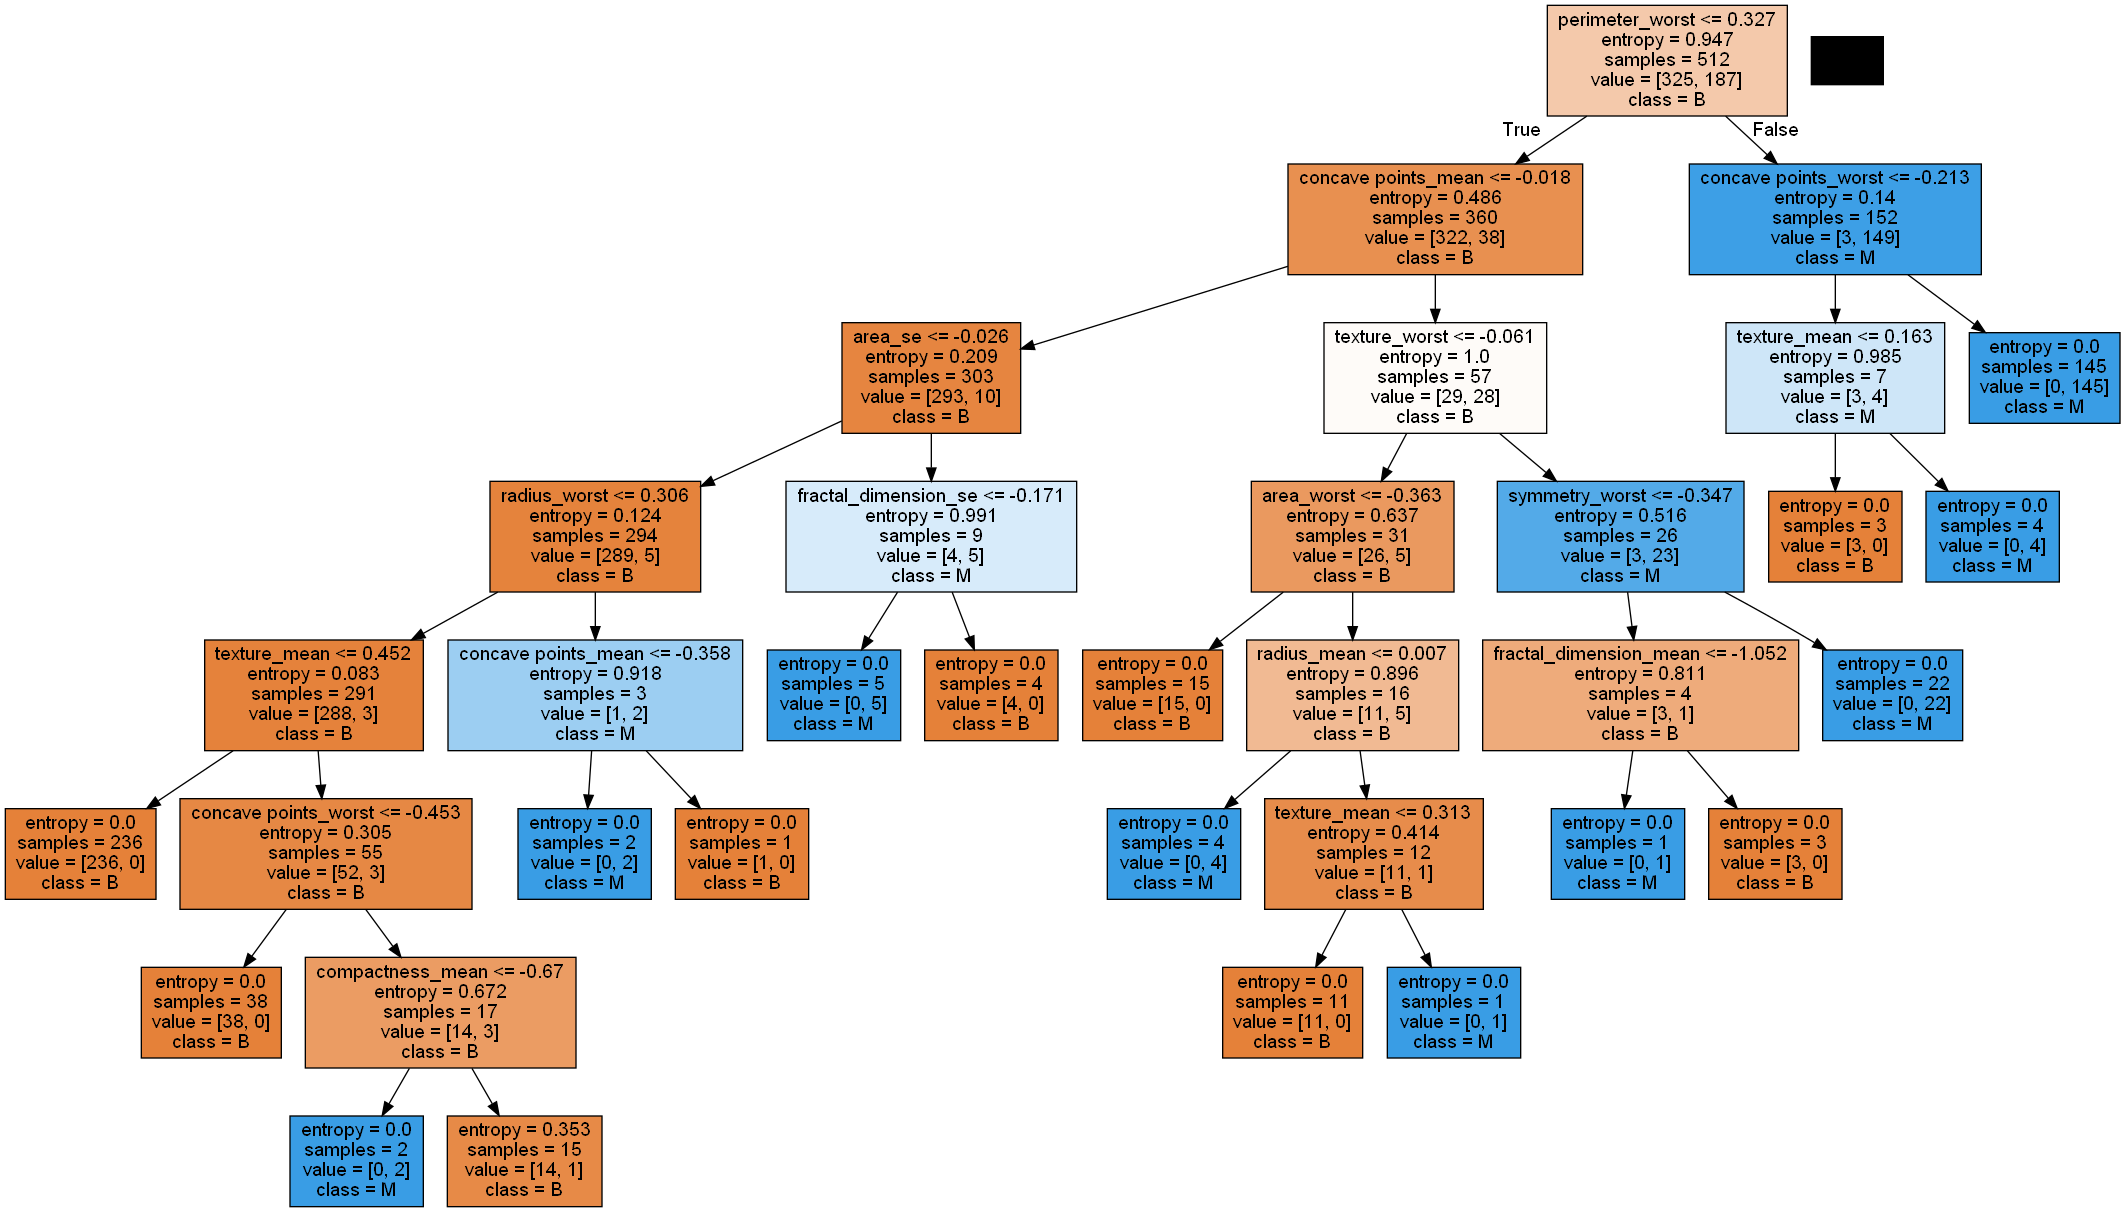

In [16]:
#Decision tree constructed from approximately 9/10 of population
y = data2['diagnosis']
X = data2.drop(columns = ['diagnosis'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10) 

dtree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=7)
dtree = dtree.fit(X_train, y_train)

tree_data = tree.export_graphviz(dtree, feature_names=x.columns, class_names=['B', 'M'], filled=True, out_file=None)
tree_graph = pydotplus.graph_from_dot_data(tree_data)
Image(tree_graph.create_png())

In [19]:
#Loops for number of trials (100) and computes total accuracy

average_accuracy = []
for i in range(100):
    y = data2['diagnosis']
    X = data2.drop(columns = ['diagnosis'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10) 

    dtree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=7)
    dtree = dtree.fit(X_train, y_train)
    y_predict = dtree.predict(X_test)
    average_accuracy.append(metrics.accuracy_score(y_predict, y_test, sample_weight=None))
print(np.mean(average_accuracy))
print(metrics.confusion_matrix(y_test, y_predict))
print(metrics.classification_report(y_test, y_predict))

0.9370175438596491
[[35  1]
 [ 1 20]]
              precision    recall  f1-score   support

           B       0.97      0.97      0.97        36
           M       0.95      0.95      0.95        21

    accuracy                           0.96        57
   macro avg       0.96      0.96      0.96        57
weighted avg       0.96      0.96      0.96        57



In addition, we decided to see if the model would perform better by selecting branches via-gini index rather than by entropy. As evidenced, using the gini index seemed to provide slightly worse results than using entropy. We conclude that this is potentially due to class imbalance present in the dataset, which the gini method is more sensitive to.

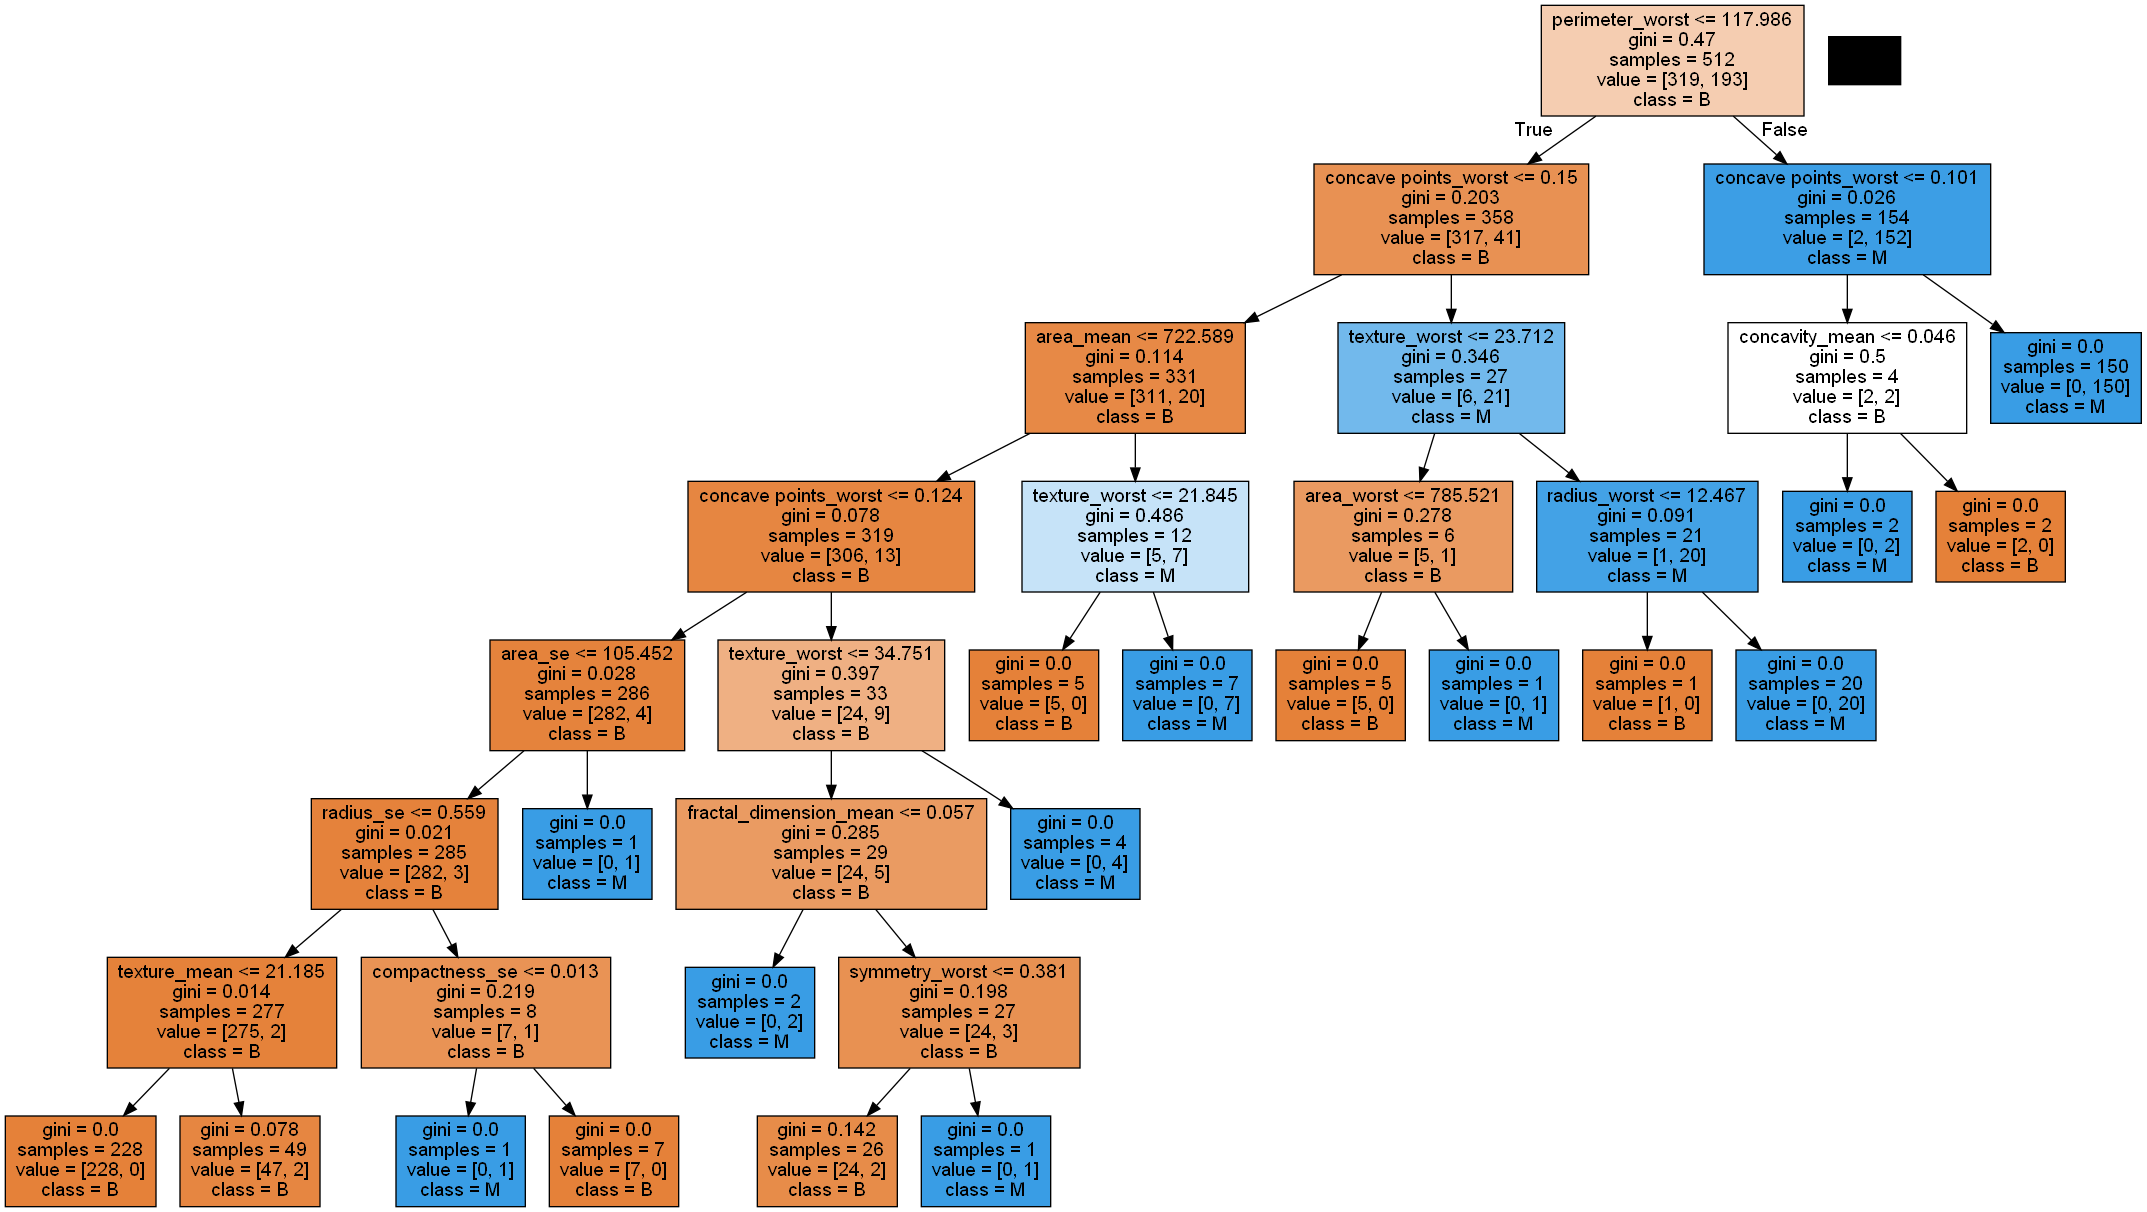

In [33]:
#Decision tree constructed from approximately 9/10 of population
y = data2['diagnosis']
X = data2.drop(columns = ['diagnosis'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10) 

dtree = tree.DecisionTreeClassifier(criterion='gini',max_depth=7)
dtree = dtree.fit(X_train, y_train)

tree_data = tree.export_graphviz(dtree, feature_names=x.columns, class_names=['B', 'M'], filled=True, out_file=None)
tree_graph = pydotplus.graph_from_dot_data(tree_data)
Image(tree_graph.create_png())

In [30]:
#Loops for number of trials (100) and computes total accuracy

average_accuracy = []
for i in range(100):
    y = data2['diagnosis']
    X = data2.drop(columns = ['diagnosis'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10) 

    dtree = tree.DecisionTreeClassifier(criterion='gini',max_depth=7)
    dtree = dtree.fit(X_train, y_train)
    y_predict = dtree.predict(X_test)
    average_accuracy.append(metrics.accuracy_score(y_predict, y_test, sample_weight=None))
print(np.mean(average_accuracy))
print(metrics.confusion_matrix(y_test, y_predict))
print(metrics.classification_report(y_test, y_predict))

0.9405263157894735
[[26  2]
 [ 2 27]]
              precision    recall  f1-score   support

           B       0.93      0.93      0.93        28
           M       0.93      0.93      0.93        29

    accuracy                           0.93        57
   macro avg       0.93      0.93      0.93        57
weighted avg       0.93      0.93      0.93        57



Overall, we considered the data as easily classifiable. For each of the tested models, prediction could be brought within 90% accuracy using only 1/10 of the data from the dataset. Through further testing, we found that the model was within 80% for sample counts as low as 10. From the data description, the model would not have derived false conclusions from class imbalance, either, as the class split was approximately 3/2. All of the used models also fell within an f1-score of 0.9, putting it another way that they performed very well.